# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 32

**Author 1 (sciper):** Julien Daniel Berger (247179)  
**Author 2 (sciper):** Ghali Chraibi (262251)   
**Author 3 (sciper):** Yasser Haddad (272292)  

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Imports

In [2]:
import tarfile
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import skimage.io
import skimage.morphology
from skimage import measure

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [3]:
data_base_path = 'data'
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1.1 Data visualization

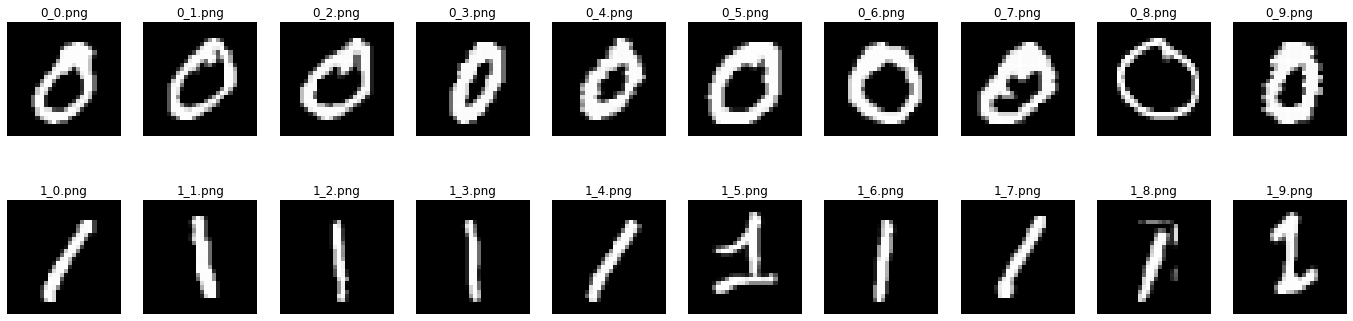

In [4]:
def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(24, 6))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.1.2 Data Preprocessing

In [5]:
### Transform the gray-scale images into binary images
#_, zeros_im_processed = cv2.threshold(zeros_im, 127, 255, cv2.THRESH_BINARY)
#_, ones_im_processed = cv2.threshold(ones_im, 127, 255, cv2.THRESH_BINARY)

#zeros_im_processed = cv2.pyrDown(zeros_im_processed)
#ones_im_processed = cv2.pyrDown(ones_im_processed)

#for i in range(5):
#    zeros_im_processed = cv2.medianBlur(zeros_im_processed, 3)
#    ones_im_processed = cv2.medianBlur(ones_im_processed, 3)

#zeros_im_processed = cv2.pyrUp(zeros_im_processed)
#ones_im_processed = cv2.pyrUp(ones_im_processed)

### Transform the gray-scale images into binary images
#_, zeros_im_processed = cv2.threshold(zeros_im_processed, 60, 255, cv2.THRESH_BINARY)
#_, ones_im_processed = cv2.threshold(ones_im_processed, 60, 255, cv2.THRESH_BINARY)

In [6]:
def extract_main_object(imgs, threshold):
    """
    Extract the biggest objects of each image in imgs.

    The threshold should be tuned empirically to remove unwanted small objects.

    Parameters
    ----------
    imgs : np.ndarray (NxMxM)
        Array of 2D images
    threshold : int
        Minimum size of objects that will be kept in the extraction process

    Returns
    -------
    np.ndarray (NxMxM)
        The array of images where the smaller objects have been removed

    """
    labeled_imgs = []
    
    for img in imgs:
        # Label the objects of img
        labeled_img = measure.label(img, background=None, connectivity=img.ndim)
        
        # Remove the small objects to keep only the main one (the digit)
        labeled_img = skimage.morphology.remove_small_objects(labeled_img, min_size=5)
        
        labeled_imgs.append(labeled_img.astype(np.uint8))
        
    return np.array(labeled_imgs)

In [7]:
def closing_on_list(imgs, kernel):
    """
    Apply a closing transformation on a list of images.

    Parameters
    ----------
    imgs : np.ndarray (NxMxM)
        Array of 2D images
    kernel : int
        Structuring element used for the closing of each image

    Returns
    -------
    np.ndarray (NxMxM)
        The array of imgs after a closing transformation

    """
    imgs_closing = []
    
    for img in imgs:
        img_closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        imgs_closing.append(img)
    
    return np.array(imgs_closing)

In [8]:
# Transform the gray-scale images into binary images
_, zeros_thresholded = cv2.threshold(zeros_im, 127, 255, cv2.THRESH_BINARY)
_, ones_thresholded = cv2.threshold(ones_im, 127, 255, cv2.THRESH_BINARY)

# For each image of 0 & 1, remove objects smaller than 5 pixels to keep only the digit
zeros_labeled = extract_main_object(zeros_thresholded, 5)
ones_labeled = extract_main_object(ones_thresholded, 5)

# Apply morphological transformations to clean the shape of the digits
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))

zeros_processed = closing_on_list(zeros_labeled, kernel)
ones_processed = closing_on_list(ones_labeled, kernel)

<ipython-input-6-78e5800fcb46>:27: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labeled_img = skimage.morphology.remove_small_objects(labeled_img, min_size=5)


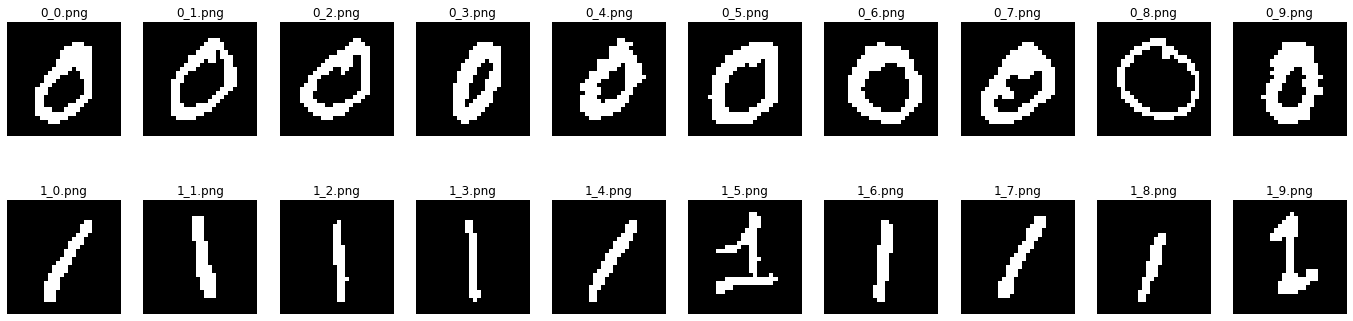

In [9]:
# Plot images
fig, axes = plt.subplots(2, len(zeros_processed), figsize=(24, 6))
for ax, im, nm in zip(axes[0], zeros_processed, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_processed, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

#### Discussion

- The use of morphological transformations for the preprocessing is limited as the images are very small (28x28). Indeed even the smallest kernel possible (2x2) have a huge impact on the objects.
- Scale up the image, apply several median filter and scale down the image helps a lot to have more homogeneous 0s and 1s, though it does not work well with the 2s and the 3s. We thus decided not to use this method as it seems to be too specific for the two first digits.

### 1.2 Fourier descriptors (15 pts)

In [70]:
def find_fourier_descriptors(img):
    """ 
    Finds and returns the Fourier descriptors of an image contour.
    
    The function first find the external contours of the image 
    
    Parameters
    ----------
    img : np.ndarray (MxM)
        A 2D image

    Returns
    -------
    np.ndarray
        The Fourier descriptors of the image
    """
    # Find the external contours of the image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Obtain the list of 2D coordinates for the external contour of the main object in the image
    digit_contour = contours[0][:,0,:]
    
    # Convert the coordinates from x-y axis to a complex representation 
    digit_contour_complex = np.empty(digit_contour.shape[:-1], dtype=complex)
    digit_contour_complex.real = digit_contour[:, 0]
    digit_contour_complex.imag = digit_contour[:, 1]
    
    fourier_descriptors = np.fft.fft(digit_contour_complex)
    
    return fourier_descriptors

In [73]:
def extract_2D_features_from_fourier_descriptors(fourier_descriptors):
    """ 
    Compute two features from the fourier descriptors.
    
    The features are invariant to translation, rotation and scaling. 
    
    Parameters
    ----------
    fourier_descriptors : np.ndarray (N,)
        An array of fourier descriptors

    Returns
    -------
    (float, float)
        A tuple containing two features based on Fourier descriptors, 
        invariant to translation, rotation and scaling.
    """
    # Take the amplitute of f1, f2 and f3 (invariant to translation and rotation)
    A1 = fourier_descriptors[1].real
    A2 = fourier_descriptors[2].real
    A3 = fourier_descriptors[3].real
    
    # Compute the ratio of two coefficients (invariant to scaling)
    feature1 = A1/A3
    feature2 = A2/A3
    
    return (feature1, feature2)

In [76]:
#zeros_features = []
#ones_features = []

#f = find_fourier_descriptors(zeros_processed[0])

numpy.ndarray

### 1.3 Additional method (5 pts)

In [10]:
# Add your implementation and discussion

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1.1 Data visualization

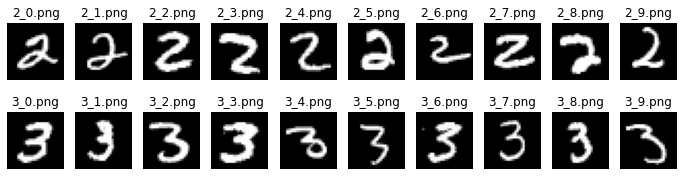

In [11]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.1.2 Data Preprocessing

**Note:** We use the same preprocessing as the one performed in part 1.1.2 for the images of 0 and 1, so that every images is treated the same way while we are trying to extract their features.

In [12]:
# Transform the gray-scale images into binary images
_, twos_thresholded = cv2.threshold(twos_im, 127, 255, cv2.THRESH_BINARY)
_, threes_thresholded = cv2.threshold(threes_im, 127, 255, cv2.THRESH_BINARY)

# For each image of 2 & 3, remove objects smaller than 5 pixels to keep only the digit
twos_labeled = extract_main_object(twos_thresholded, 5)
threes_labeled = extract_main_object(threes_thresholded, 5)

# Apply morphological transformations to clean the shape of the digits
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))

twos_processed = closing_on_list(twos_labeled, kernel)
threes_processed = closing_on_list(threes_labeled, kernel)

<ipython-input-5-78e5800fcb46>:27: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labeled_img = skimage.morphology.remove_small_objects(labeled_img, min_size=5)


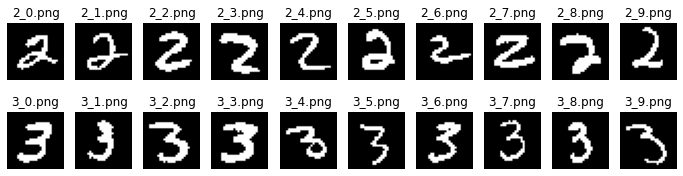

In [13]:
# Plot images
fig, axes = plt.subplots(2, len(twos_processed), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_processed, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_processed, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [14]:
# Add your implementation and discussion